In [1]:
# Import the necessary libraries

import datetime, warnings, scipy
import pandas as pd
import numpy as np
import seaborn as sns  # graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

# graphic styles
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

# display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50

# jupyter command
%matplotlib inline  
warnings.filterwarnings("ignore")

In [2]:
# Import the functions from Keras and skLearn libraries

from keras.models import Sequential  # sequential TensorFlow model
from keras.layers import Dense  # standard nn layer
from keras.layers import LSTM  # Long Short Term Memory nn layer
from sklearn.preprocessing import MinMaxScaler, StandardScaler  # to preedit our data
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('Data/air_quality.csv', sep=' ')
df.head()

,No,Profile,Tanggal,Jam,O3,CO,NO2,SO2,NO,CO2,VOC,PM1,PM2.5,PM4,PM10,TSP,TEMP,HUM,WS,WD,ISPU,Status,Unnamed: 22
0,1,BANDUNG,2019-05-19,00:04:19,21.35,0.78,6.77,14.06,26.168,409.86,251.202,0.0,0.0,0.0,2.77,0.0,21.4,100.0,0.600,5,9,BAIK,NaN
1,2,BANDUNG,2019-05-19,00:15:01,5.93,0.82,14.87,17.23,53.853,394.79,501.356,0.0,0.0,0.0,11.95,0.0,42.6,200.0,0.000,2,12,BAIK,NaN
2,3,BANDUNG,2019-05-19,00:30:06,6.62,0.63,22.24,2.31,38.304,390.66,753.291,0.0,0.0,0.0,12.71,0.0,63.6,299.2,0.000,2,13,BAIK,NaN
3,4,BANDUNG,2019-05-19,00:49:19,13.29,0.44,19.00,5.32,18.962,401.23,251.043,0.0,0.0,0.0,1.20,0.0,21.3,88.2,0.525,5,6,BAIK,NaN
4,5,BANDUNG,2019-05-19,01:04:19,2.44,0.47,26.74,13.61,35.270,381.67,250.471,0.0,0.0,0.0,3.52,0.0,21.3,97.4,0.975,5,9,BAIK,NaN


In [4]:
# Convert TIME to datetime format:

def combine_date(df, tab_name):
    list_tab = []
    for i in range(df.shape[0]):
        list_tab.append(df.loc[i, 'Tanggal'] + 'T' + df.loc[i, tab_name][0:2])
    return np.array(list_tab, dtype='datetime64')

df['Datetime'] = combine_date(df, 'Jam')

# Convert into hourly data
df = df[['Datetime','O3','CO','NO2', 'SO2', 'NO', 'CO2', 'VOC', 'PM1', 'PM2.5', 'PM4', 'PM10', 'TSP', 'TEMP', 'HUM', 'WS', 'WD', 'ISPU']]

df2 = df.groupby(['Datetime']).mean()

df.head()

,Datetime,O3,CO,NO2,SO2,NO,CO2,VOC,PM1,PM2.5,PM4,PM10,TSP,TEMP,HUM,WS,WD,ISPU
0,2019-05-19 00:00:00,21.35,0.78,6.77,14.06,26.168,409.86,251.202,0.0,0.0,0.0,2.77,0.0,21.4,100.0,0.600,5,9
1,2019-05-19 00:00:00,5.93,0.82,14.87,17.23,53.853,394.79,501.356,0.0,0.0,0.0,11.95,0.0,42.6,200.0,0.000,2,12
2,2019-05-19 00:00:00,6.62,0.63,22.24,2.31,38.304,390.66,753.291,0.0,0.0,0.0,12.71,0.0,63.6,299.2,0.000,2,13
3,2019-05-19 00:00:00,13.29,0.44,19.00,5.32,18.962,401.23,251.043,0.0,0.0,0.0,1.20,0.0,21.3,88.2,0.525,5,6
4,2019-05-19 01:00:00,2.44,0.47,26.74,13.61,35.270,381.67,250.471,0.0,0.0,0.0,3.52,0.0,21.3,97.4,0.975,5,9


In [5]:
# Descriptive statistics of the variables

df2.describe()

,O3,CO,NO2,SO2,NO,CO2,VOC,PM1,PM2.5,PM4,PM10,TSP,TEMP,HUM,WS,WD,ISPU
count,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000
mean,8.538909,0.233172,16.681910,12.013894,37.086256,394.616480,260.053778,0.309564,0.383692,0.451982,6.157770,0.562012,25.266942,77.634191,24.291226,7.129031,10.097848
std,3.997292,0.388102,5.373487,4.411251,12.521778,4.180224,60.773321,2.286104,2.874126,3.378291,4.149511,4.184787,6.707977,29.743129,51.993683,3.523245,5.049788
min,0.270000,0.010000,2.040000,2.162500,3.128750,380.420000,187.518000,0.000000,0.000000,0.000000,0.885000,0.000000,11.250000,26.866667,0.000000,0.000000,4.250000
25%,5.881667,0.083333,13.010000,9.015000,28.443500,391.830000,247.798333,0.000000,0.000000,0.000000,4.340000,0.000000,21.266667,57.850000,0.237500,4.666667,8.166667
50%,7.813333,0.160000,15.916667,11.730000,39.252250,394.602000,250.926250,0.000000,0.000000,0.000000,5.571667,0.000000,24.100000,77.083333,1.312500,5.833333,9.500000
75%,10.373333,0.296667,19.935000,14.595000,46.015500,397.415000,253.286667,0.000000,0.000000,0.000000,7.090000,0.000000,28.400000,94.066667,5.075000,10.500000,11.000000
max,33.741667,13.950000,99.600000,46.290000,194.554000,408.820000,1240.713500,51.600000,68.700000,79.800000,91.600000,92.900000,124.600000,313.400000,199.200000,15.000000,156.500000


In [6]:
# Calculate quantile for each variable

def calculate_quantile(i, df2):
    Q1 = df2[[i]].quantile(0.25)[0]
    Q3 = df2[[i]].quantile(0.75)[0]
    IQR = Q3 - Q1
    min = df2[[i]].min()[0]
    max = df2[[i]].max()[0]
    min_IQR = Q1 - 1.5*IQR
    max_IQR = Q3 + 1.5*IQR
    
    return Q1, Q3, min, max, min_IQR, max_IQR

# delete first and last rows to avoid missing value extrapolation
df2.drop(index=[df2.index[0], df2.index[df2.shape[0]-1]], inplace=True)

# find and interpolate the outliers
for i in df2.columns:
    print('\nAttribute-',i,':')
    Q1, Q3, min, max, min_IQR, max_IQR = calculate_quantile(i, df2)
    print('Q1 = %.2f' % Q1)
    print('Q3 = %.2f' % Q3)
    print('min IQR = %.2f' % min_IQR)
    print('max IQR = %.2f' % max_IQR)
    if(min < min_IQR):
        print('---> Low outlier is found = %.2f' % min)
        
    if(max > max_IQR):
        print('---> High outlier is found = %.2f' % max)

    def convert_nan (x, max_IQR=max_IQR, min_IQR=min_IQR):
        if((x > max_IQR) | (x < min_IQR)):
            x = np.nan  # Null to clear the outliers
        return x

    def convert_nan_HUM (x, max_IQR=100.0, min_IQR=min_IQR):
        if ((x > max_IQR) | (x < min_IQR)):
            x = np.nan
        return x
    
    if (i == 'HUM'):
        df2[i] = df2[i].map(convert_nan_HUM)
    if (i != 'HUM'):
        df2[i] = df2[i].map(convert_nan)
    df2[i] = df2[i].interpolate(method='linear')

    if (len(df2[df2[i].isnull()][i]) == 0):
        print('################ Outliers have been interpolated ################')


Attribute- O3 :
Q1 = 5.88
Q3 = 10.37
min IQR = -0.85
max IQR = 17.10
---> High outlier is found = 33.74
################ Outliers have been interpolated ################

Attribute- CO :
Q1 = 0.08
Q3 = 0.30
min IQR = -0.24
max IQR = 0.62
---> High outlier is found = 13.95
################ Outliers have been interpolated ################

Attribute- NO2 :
Q1 = 13.01
Q3 = 19.93
min IQR = 2.62
max IQR = 30.32
---> Low outlier is found = 2.04
---> High outlier is found = 99.60
################ Outliers have been interpolated ################

Attribute- SO2 :
Q1 = 9.00
Q3 = 14.61
min IQR = 0.60
max IQR = 23.01
---> High outlier is found = 46.29
################ Outliers have been interpolated ################

Attribute- NO :
Q1 = 28.44
Q3 = 46.02
min IQR = 2.09
max IQR = 72.37
---> High outlier is found = 194.55
################ Outliers have been interpolated ################

Attribute- CO2 :
Q1 = 391.83
Q3 = 397.41
min IQR = 383.47
max IQR = 405.77
---> Low outlier is found = 380.42
-

In [7]:
# log transformation to deal with skewed data

dataset = np.log1p(df2[['TEMP']].values)
dataset.shape

(1735, 1)

<Figure size 864x360 with 0 Axes>

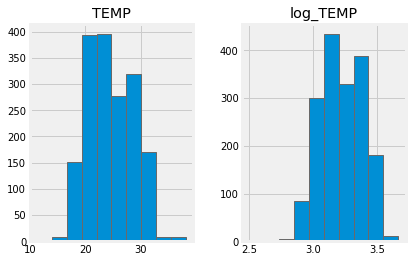

In [8]:
# Create new dataframe to compare the original vs log transform data
dist_df = pd.DataFrame({'TEMP' : df2['TEMP'].values, 'log_TEMP' : dataset[:,0]})

# Histogram plot original vs log transform data
plt.figure(figsize=(12,5))
dist_df.hist();

In [9]:
# Split the dataset into train and test sets

train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1301 434


In [10]:
# Convert an array of values into a dataset matrix

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape the train and test data

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print('Shape of trainX :', trainX.shape)
print('Shape of trainY :', trainY.shape)
print('Shape of testX :', testX.shape)
print('Shape of testY :', testY.shape)

Shape of trainX : (1299, 1)
Shape of trainY : (1299,)
Shape of testX : (432, 1)
Shape of testY : (432,)


In [11]:
# Reshape the input array in the form - [samples, time steps, features]

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Shape of trainX :', trainX.shape)
print('Shape of testX :', testX.shape)

Shape of trainX : (1299, 1, 1)
Shape of testX : (432, 1, 1)


In [12]:
# Create and fit the LSTM Neural Network

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=300, batch_size=32, verbose=2)

Epoch 1/300
41/41 - 1s - loss: 10.6075 - 1s/epoch - 34ms/step
Epoch 2/300
41/41 - 0s - loss: 10.0273 - 44ms/epoch - 1ms/step
Epoch 3/300
41/41 - 0s - loss: 9.3417 - 45ms/epoch - 1ms/step
Epoch 4/300
41/41 - 0s - loss: 8.4368 - 46ms/epoch - 1ms/step
Epoch 5/300
41/41 - 0s - loss: 7.3344 - 45ms/epoch - 1ms/step
Epoch 6/300
41/41 - 0s - loss: 6.1534 - 44ms/epoch - 1ms/step
Epoch 7/300
41/41 - 0s - loss: 5.0167 - 46ms/epoch - 1ms/step
Epoch 8/300
41/41 - 0s - loss: 3.9859 - 45ms/epoch - 1ms/step
Epoch 9/300
41/41 - 0s - loss: 3.0887 - 44ms/epoch - 1ms/step
Epoch 10/300
41/41 - 0s - loss: 2.3517 - 46ms/epoch - 1ms/step
Epoch 11/300
41/41 - 0s - loss: 1.7744 - 44ms/epoch - 1ms/step
Epoch 12/300
41/41 - 0s - loss: 1.3333 - 42ms/epoch - 1ms/step
Epoch 13/300
41/41 - 0s - loss: 0.9988 - 46ms/epoch - 1ms/step
Epoch 14/300
41/41 - 0s - loss: 0.7460 - 47ms/epoch - 1ms/step
Epoch 15/300
41/41 - 0s - loss: 0.5552 - 48ms/epoch - 1ms/step
Epoch 16/300
41/41 - 0s - loss: 0.4118 - 44ms/epoch - 1ms/step


Epoch 131/300
41/41 - 0s - loss: 0.0163 - 43ms/epoch - 1ms/step
Epoch 132/300
41/41 - 0s - loss: 0.0163 - 42ms/epoch - 1ms/step
Epoch 133/300
41/41 - 0s - loss: 0.0162 - 45ms/epoch - 1ms/step
Epoch 134/300
41/41 - 0s - loss: 0.0161 - 43ms/epoch - 1ms/step
Epoch 135/300
41/41 - 0s - loss: 0.0160 - 48ms/epoch - 1ms/step
Epoch 136/300
41/41 - 0s - loss: 0.0159 - 46ms/epoch - 1ms/step
Epoch 137/300
41/41 - 0s - loss: 0.0159 - 46ms/epoch - 1ms/step
Epoch 138/300
41/41 - 0s - loss: 0.0158 - 43ms/epoch - 1ms/step
Epoch 139/300
41/41 - 0s - loss: 0.0157 - 45ms/epoch - 1ms/step
Epoch 140/300
41/41 - 0s - loss: 0.0156 - 47ms/epoch - 1ms/step
Epoch 141/300
41/41 - 0s - loss: 0.0155 - 43ms/epoch - 1ms/step
Epoch 142/300
41/41 - 0s - loss: 0.0155 - 45ms/epoch - 1ms/step
Epoch 143/300
41/41 - 0s - loss: 0.0154 - 45ms/epoch - 1ms/step
Epoch 144/300
41/41 - 0s - loss: 0.0153 - 44ms/epoch - 1ms/step
Epoch 145/300
41/41 - 0s - loss: 0.0153 - 42ms/epoch - 1ms/step
Epoch 146/300
41/41 - 0s - loss: 0.0151 

Epoch 259/300
41/41 - 0s - loss: 0.0090 - 43ms/epoch - 1ms/step
Epoch 260/300
41/41 - 0s - loss: 0.0090 - 45ms/epoch - 1ms/step
Epoch 261/300
41/41 - 0s - loss: 0.0091 - 45ms/epoch - 1ms/step
Epoch 262/300
41/41 - 0s - loss: 0.0090 - 47ms/epoch - 1ms/step
Epoch 263/300
41/41 - 0s - loss: 0.0089 - 43ms/epoch - 1ms/step
Epoch 264/300
41/41 - 0s - loss: 0.0089 - 44ms/epoch - 1ms/step
Epoch 265/300
41/41 - 0s - loss: 0.0089 - 50ms/epoch - 1ms/step
Epoch 266/300
41/41 - 0s - loss: 0.0089 - 48ms/epoch - 1ms/step
Epoch 267/300
41/41 - 0s - loss: 0.0089 - 45ms/epoch - 1ms/step
Epoch 268/300
41/41 - 0s - loss: 0.0089 - 44ms/epoch - 1ms/step
Epoch 269/300
41/41 - 0s - loss: 0.0090 - 45ms/epoch - 1ms/step
Epoch 270/300
41/41 - 0s - loss: 0.0088 - 46ms/epoch - 1ms/step
Epoch 271/300
41/41 - 0s - loss: 0.0089 - 44ms/epoch - 1ms/step
Epoch 272/300
41/41 - 0s - loss: 0.0090 - 44ms/epoch - 1ms/step
Epoch 273/300
41/41 - 0s - loss: 0.0089 - 46ms/epoch - 1ms/step
Epoch 274/300
41/41 - 0s - loss: 0.0089 

In [13]:
# Make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert Predictions

trainPredict = np.expm1(trainPredict)
trainY = np.expm1(trainY)
testPredict = np.expm1(testPredict)
testY = np.expm1(testY)

# Calculate root mean squared error

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Train Score: %.2f RMSE' % (testScore))

14/14 [==============================] - 0s 905us/step
Train Score: 2.36 RMSE
Train Score: 3.13 RMSE


In [14]:
test_series = pd.Series(testY)

# State of model performance

if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test predicitons < Standard deiation of test dataet')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test predicitons > Standard deiation of test dataet')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))


[ Model performance is GOOD enough ]

RMSE of test predicitons < Standard deiation of test dataet
3.13 < 4.40


(1360.0, 1735.0)

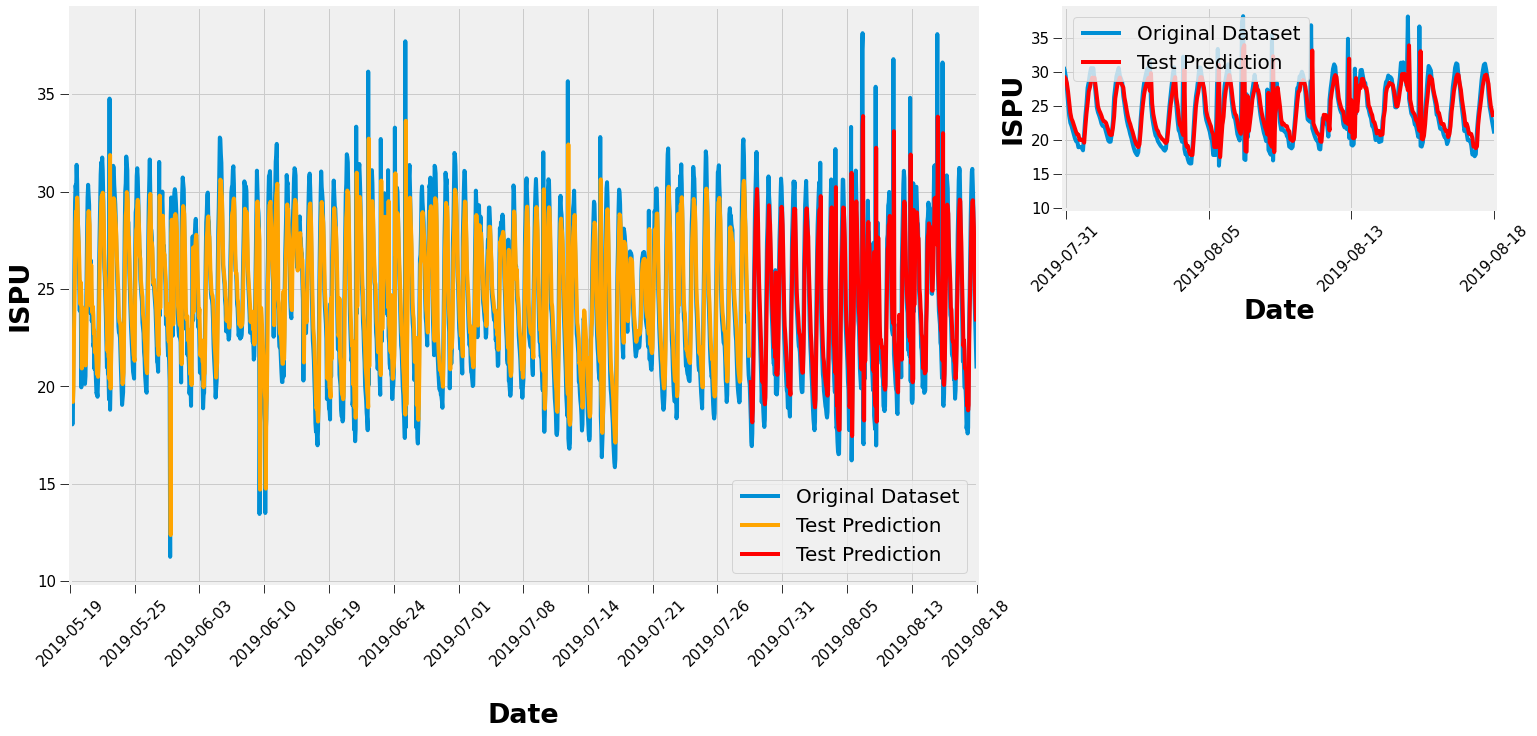

In [18]:
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Plot original dataset and predictions
time_axis = np.linspace(0, dataset.shape[0]-1, 15)
time_axis = np.array([int(i) for i in time_axis])
time_axisLab = np.array(df2.index, dtype='datetime64[D]')

fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])
ax.plot(np.expm1(dataset), label='Original Dataset')
ax.plot(trainPredictPlot, color='orange', label='Test Prediction')
ax.plot(testPredictPlot, color='red', label='Test Prediction')
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax.set_xlabel('\nDate', fontsize=27, fontweight='bold')
ax.set_ylabel('ISPU', fontsize=27, fontweight='bold')
ax.legend(loc='best', prop={'size':20})
ax.tick_params(size=10, labelsize=15)
ax.set_xlim([-1,1735])

ax1 = fig.add_axes([2.3, 1.3, 1, 0.7])
ax1.plot(np.expm1(dataset), label='Original Dataset')
ax1.plot(testPredictPlot, color='red', label='Test Prediction')
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax1.set_xlabel('Date', fontsize=27, fontweight='bold')
ax1.set_ylabel('ISPU', fontsize=27, fontweight='bold')
ax1.legend(loc='best', prop={'size':20})
ax1.tick_params(size=10, labelsize=15)
ax1.set_xlim([1360,1735])